In [1]:
import socket
import pickle
import numpy as np
import os
import time
import subprocess
import matplotlib.pyplot as plt
from game.run import Agent

from tensorflow.keras import layers, models, utils

import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.eager import backprop

In [2]:
interpretator = os.path.join(os.getcwd(), ".venv", "bin", "python")

agent = Agent(interpretator, save_video=True)
agent.run()

done = False
while not done:
    state, direct, rewart, done = agent.get_env()
    print(state.shape)
    agent.step_to(1)

client = socket.create_connection(("127.0.0.1", 8989))

client.recv(1024*1000)
client.send(pickle.dumps(1))

def create_agent(interpretator, video=False):
    agent = Agent(interpretator, save_video=video)
    # agent.run()
    return agent

In [3]:
def process_reward(rewards):
    rew_decay = 0.9
    tmp_decay = 0
    rew_decayed = []
    for el in rewards[::-1]:
        if el == 0:
            tmp_decay = tmp_decay * rew_decay
            rew_decayed.append(tmp_decay)
        else:
            rew_decayed.append(el)
            tmp_decay = el
    rewards = np.asarray(rew_decayed[::-1], dtype=np.float32)
    rewards -= np.mean(rewards)
    rewards /= np.std(rewards)
    return rewards

In [4]:
AGENT = Agent(interpretator)
def get_data(model, epoch):
    global AGENT
    done = False
    X = []
    rewards = []
    y = []
    AGENT.run()
    while not done:
        state, direct, reward, done = AGENT.get_env()
        pred = model.predict(np.expand_dims(state, axis=0))
        AGENT.step_to(pred[0].argmax())
        X.append(state)
        rewards.append(reward)
        y.append(utils.to_categorical(direct, num_classes=4))
    result = (
        np.asarray(X, dtype=np.float32),
        np.asarray(y, dtype=np.float32),
        np.asarray(rewards, dtype=np.float32)
    )
    return result


In [5]:
(120, 160)

(120, 160)

In [6]:
n = 4
input_image = layers.Input(shape=(120, 160))

x = input_image
x = layers.Conv1D(32 * n, 3, activation="elu")(x)
x = layers.Conv1D(24 * n, 4, activation="elu")(x)
x = layers.Conv1D(16 * n, 5, activation="elu")(x)
x = layers.Conv1D(8 * n, 6, activation="elu")(x)
x = layers.Conv1D(4 * n, 7, activation="elu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(2 * n, activation="elu")(x)
x = layers.Dense(4, activation="sigmoid")(x)

output_actions = x

model = models.Model(input_image, output_actions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 118, 128)          61568     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 115, 96)           49248     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 111, 64)           30784     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 106, 32)           12320     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 16)           3600      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0     

In [7]:
class TrainModel(models.Model):
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)
        with backprop.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(
                y, y_pred, sample_weight,
                regularization_losses=self.losses
            )
            loss = tf.math.multiply(loss, x[1])
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        return {m.name: m.result() for m in self.metrics}

In [8]:
rew = layers.Input(shape=(1,))
train_model = TrainModel([input_image, rew], output_actions)

train_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
def train(model, train_model, epochs):
    losses = []
    rews = []
    for i in range(1, epochs+1):
        X_train, y_train, rewards = get_data(model, i)
        while X_train.shape[0] < 32:
            x, y, r = get_data(model, i)
            X_train = np.concatenate((X_train, x), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)
            rewards = np.concatenate((rewards, r), axis=0)

        rewards = process_reward(rewards)
        history = train_model.fit(
            [X_train, rewards],
            y_train,
            epochs=5,
            batch_size=32,
        )
        # losses.append(history)
        print("epoch", i)
        plt.plot(rewards)
        plt.show()
    return losses

Epoch 1/5
2/2 [==============================] - 1s 4ms/step - loss: 1.5358 - accuracy: 0.4899
Epoch 2/5
2/2 [==============================] - 0s 4ms/step - loss: 1.8591 - accuracy: 0.1531
Epoch 3/5
2/2 [==============================] - 0s 5ms/step - loss: 2.5040 - accuracy: 0.0919
Epoch 4/5
2/2 [==============================] - 0s 4ms/step - loss: 2.1528 - accuracy: 0.0919
Epoch 5/5
2/2 [==============================] - 0s 6ms/step - loss: 2.6313 - accuracy: 0.0612
epoch 1


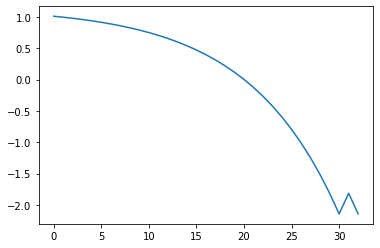

Epoch 1/5
2/2 [==============================] - 0s 12ms/step - loss: 1.7927 - accuracy: 0.5833
Epoch 2/5
2/2 [==============================] - 0s 14ms/step - loss: 1.7708 - accuracy: 0.6042
Epoch 3/5
2/2 [==============================] - 0s 13ms/step - loss: 1.7254 - accuracy: 0.5625
Epoch 4/5
2/2 [==============================] - 0s 14ms/step - loss: 1.8069 - accuracy: 0.6042
Epoch 5/5
2/2 [==============================] - 0s 14ms/step - loss: 1.7138 - accuracy: 0.5833
epoch 2


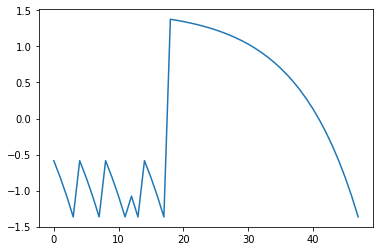

Epoch 1/5
3/3 [==============================] - 0s 14ms/step - loss: 1.4064 - accuracy: 0.6429
Epoch 2/5
3/3 [==============================] - 0s 16ms/step - loss: 1.1774 - accuracy: 0.6857
Epoch 3/5
3/3 [==============================] - 0s 14ms/step - loss: 1.0255 - accuracy: 0.7714
Epoch 4/5
3/3 [==============================] - 0s 14ms/step - loss: 1.1691 - accuracy: 0.7857
Epoch 5/5
3/3 [==============================] - 0s 15ms/step - loss: 1.2478 - accuracy: 0.6429
epoch 3


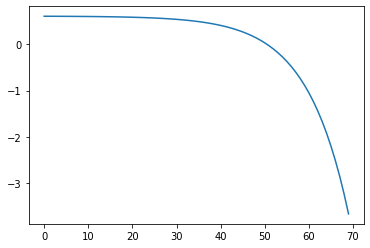

Epoch 1/5
1/1 [==============================] - 0s 371ms/step - loss: 1.9690 - accuracy: 0.0938
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 2.0112 - accuracy: 0.0625
Epoch 3/5
1/1 [==============================] - 0s 22ms/step - loss: 1.9443 - accuracy: 0.1250
Epoch 4/5
1/1 [==============================] - 0s 23ms/step - loss: 1.9514 - accuracy: 0.1562
Epoch 5/5
1/1 [==============================] - 0s 22ms/step - loss: 1.8611 - accuracy: 0.1250
epoch 4


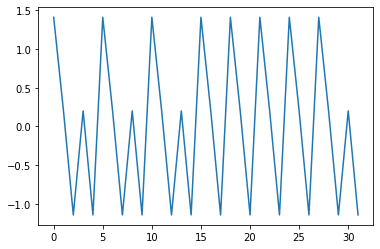

Epoch 1/5
2/2 [==============================] - 0s 5ms/step - loss: 1.8769 - accuracy: 0.1176
Epoch 2/5
2/2 [==============================] - 0s 6ms/step - loss: 1.7117 - accuracy: 0.2059
Epoch 3/5
2/2 [==============================] - 0s 7ms/step - loss: 1.6405 - accuracy: 0.1471
Epoch 4/5
2/2 [==============================] - 0s 13ms/step - loss: 1.5407 - accuracy: 0.5588
Epoch 5/5
2/2 [==============================] - 0s 6ms/step - loss: 1.1217 - accuracy: 0.6176
epoch 5


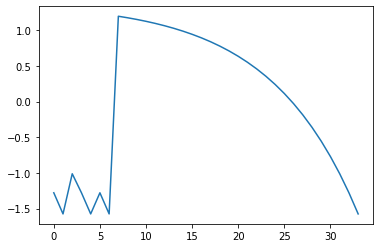

Epoch 1/5
4/4 [==============================] - 0s 22ms/step - loss: 0.9085 - accuracy: 0.6727
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.9786 - accuracy: 0.6273
Epoch 3/5
4/4 [==============================] - 0s 19ms/step - loss: 0.8965 - accuracy: 0.6909
Epoch 4/5
4/4 [==============================] - 0s 22ms/step - loss: 0.7906 - accuracy: 0.7182
Epoch 5/5
4/4 [==============================] - 0s 18ms/step - loss: 0.7237 - accuracy: 0.7909
epoch 6


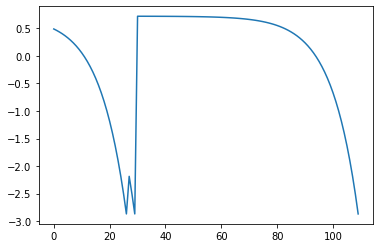

Epoch 1/5
1/1 [==============================] - 0s 19ms/step - loss: 1.5496 - accuracy: 0.7500
Epoch 2/5
1/1 [==============================] - 0s 21ms/step - loss: 1.5445 - accuracy: 0.7500
Epoch 3/5
1/1 [==============================] - 0s 21ms/step - loss: 1.4682 - accuracy: 0.7188
Epoch 4/5
1/1 [==============================] - 0s 25ms/step - loss: 1.4785 - accuracy: 0.7500
Epoch 5/5
1/1 [==============================] - 0s 25ms/step - loss: 1.6416 - accuracy: 0.7188
epoch 7


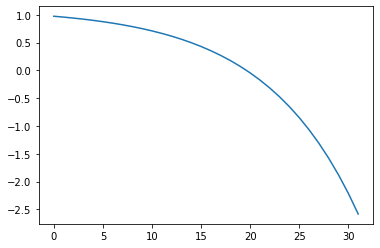

Epoch 1/5
2/2 [==============================] - 0s 19ms/step - loss: 0.6484 - accuracy: 0.7619
Epoch 2/5
2/2 [==============================] - 0s 23ms/step - loss: 0.6801 - accuracy: 0.8095
Epoch 3/5
2/2 [==============================] - 0s 23ms/step - loss: 0.6516 - accuracy: 0.8095
Epoch 4/5
2/2 [==============================] - 0s 24ms/step - loss: 0.7995 - accuracy: 0.8254
Epoch 5/5
2/2 [==============================] - 0s 21ms/step - loss: 0.8801 - accuracy: 0.8095
epoch 8


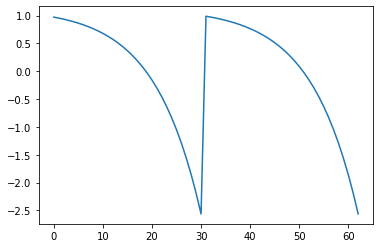

Epoch 1/5
2/2 [==============================] - 0s 17ms/step - loss: 1.5926 - accuracy: 0.4211
Epoch 2/5
2/2 [==============================] - 0s 21ms/step - loss: 1.7875 - accuracy: 0.3860
Epoch 3/5
2/2 [==============================] - 0s 20ms/step - loss: 1.6445 - accuracy: 0.2632
Epoch 4/5
2/2 [==============================] - 0s 19ms/step - loss: 1.6936 - accuracy: 0.3158
Epoch 5/5
2/2 [==============================] - 0s 21ms/step - loss: 1.5853 - accuracy: 0.2982
epoch 9


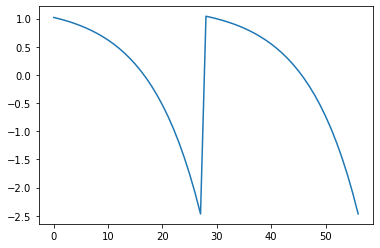

Epoch 1/5
3/3 [==============================] - 0s 13ms/step - loss: 0.9909 - accuracy: 0.5909
Epoch 2/5
3/3 [==============================] - 0s 16ms/step - loss: 0.9639 - accuracy: 0.6667
Epoch 3/5
3/3 [==============================] - 0s 16ms/step - loss: 0.9943 - accuracy: 0.6364
Epoch 4/5
3/3 [==============================] - 0s 15ms/step - loss: 1.1543 - accuracy: 0.6061
Epoch 5/5
3/3 [==============================] - 0s 15ms/step - loss: 1.2074 - accuracy: 0.6364
epoch 10


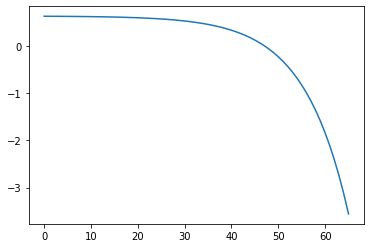

In [10]:
errors = train(model, train_model, 10000)